In [5]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:        
        a=1


In [6]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  


import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
import gif_your_nifti.core as gif2nif


import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
 

np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-bjn0y90r
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-bjn0y90r
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif_your_nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6633 sha256=eb8830596f8feb77e997757426c12f8e311f9329d720c061066e278b643ca797
  Stored in directory: /tmp/pip-ephem-wheel-cache-ylw_tfir/wheels/3a/c2/0b/c08f2425925519bb014e107d2919dadc2556ec5e7c205e4472
Successfully built gif_your_nifti


In [7]:
  SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}
 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

Text(0.5, 1.0, 'Mask')

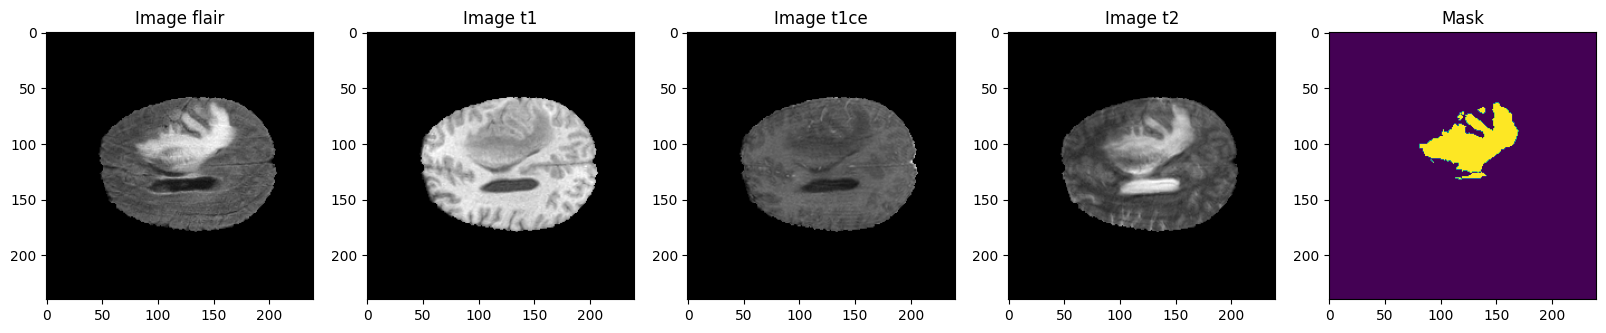

In [8]:
TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

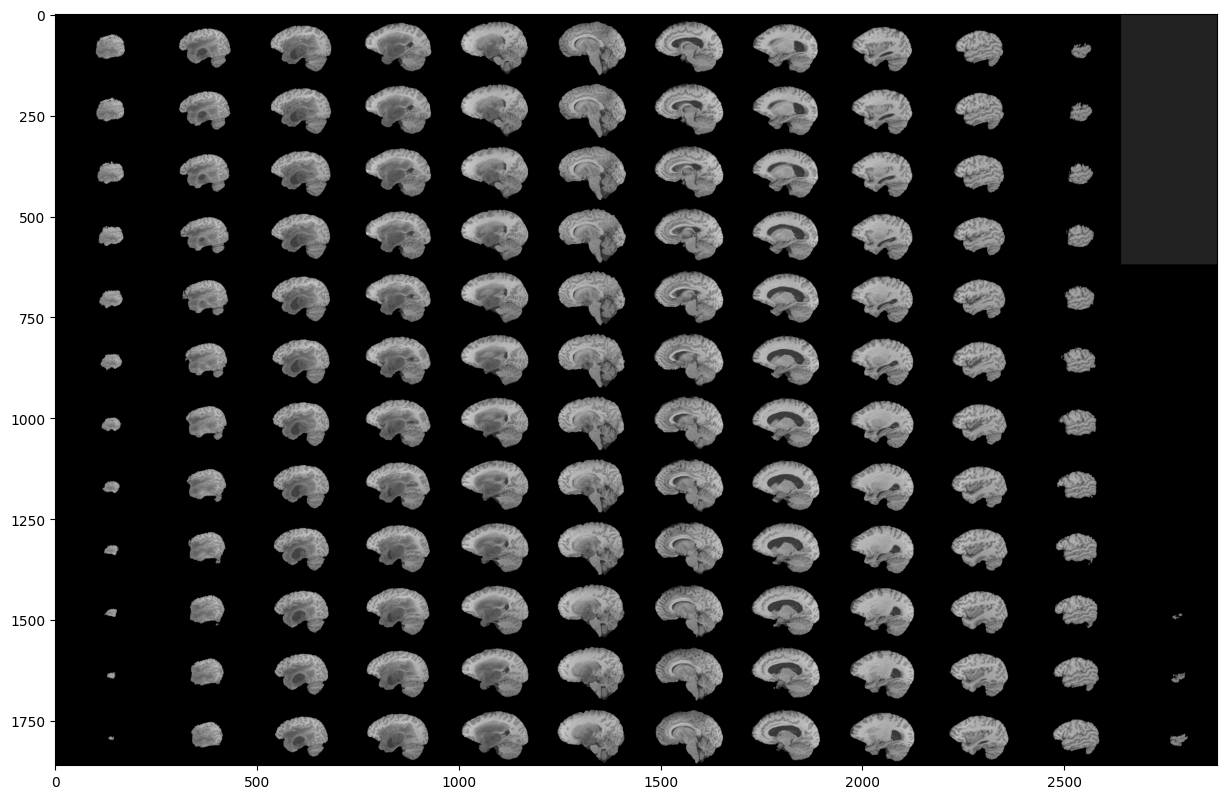

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

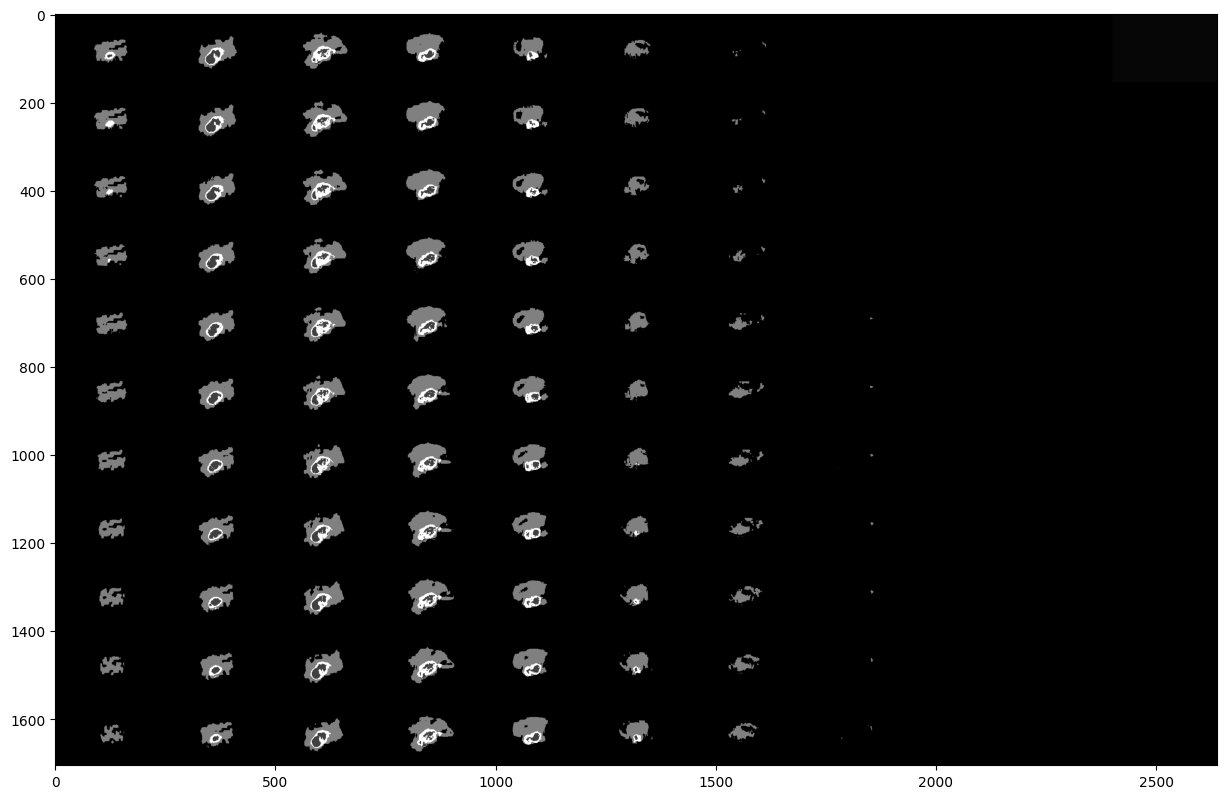

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [11]:
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii', './test_gif_BraTS20_Training_001_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_001_flair.nii')

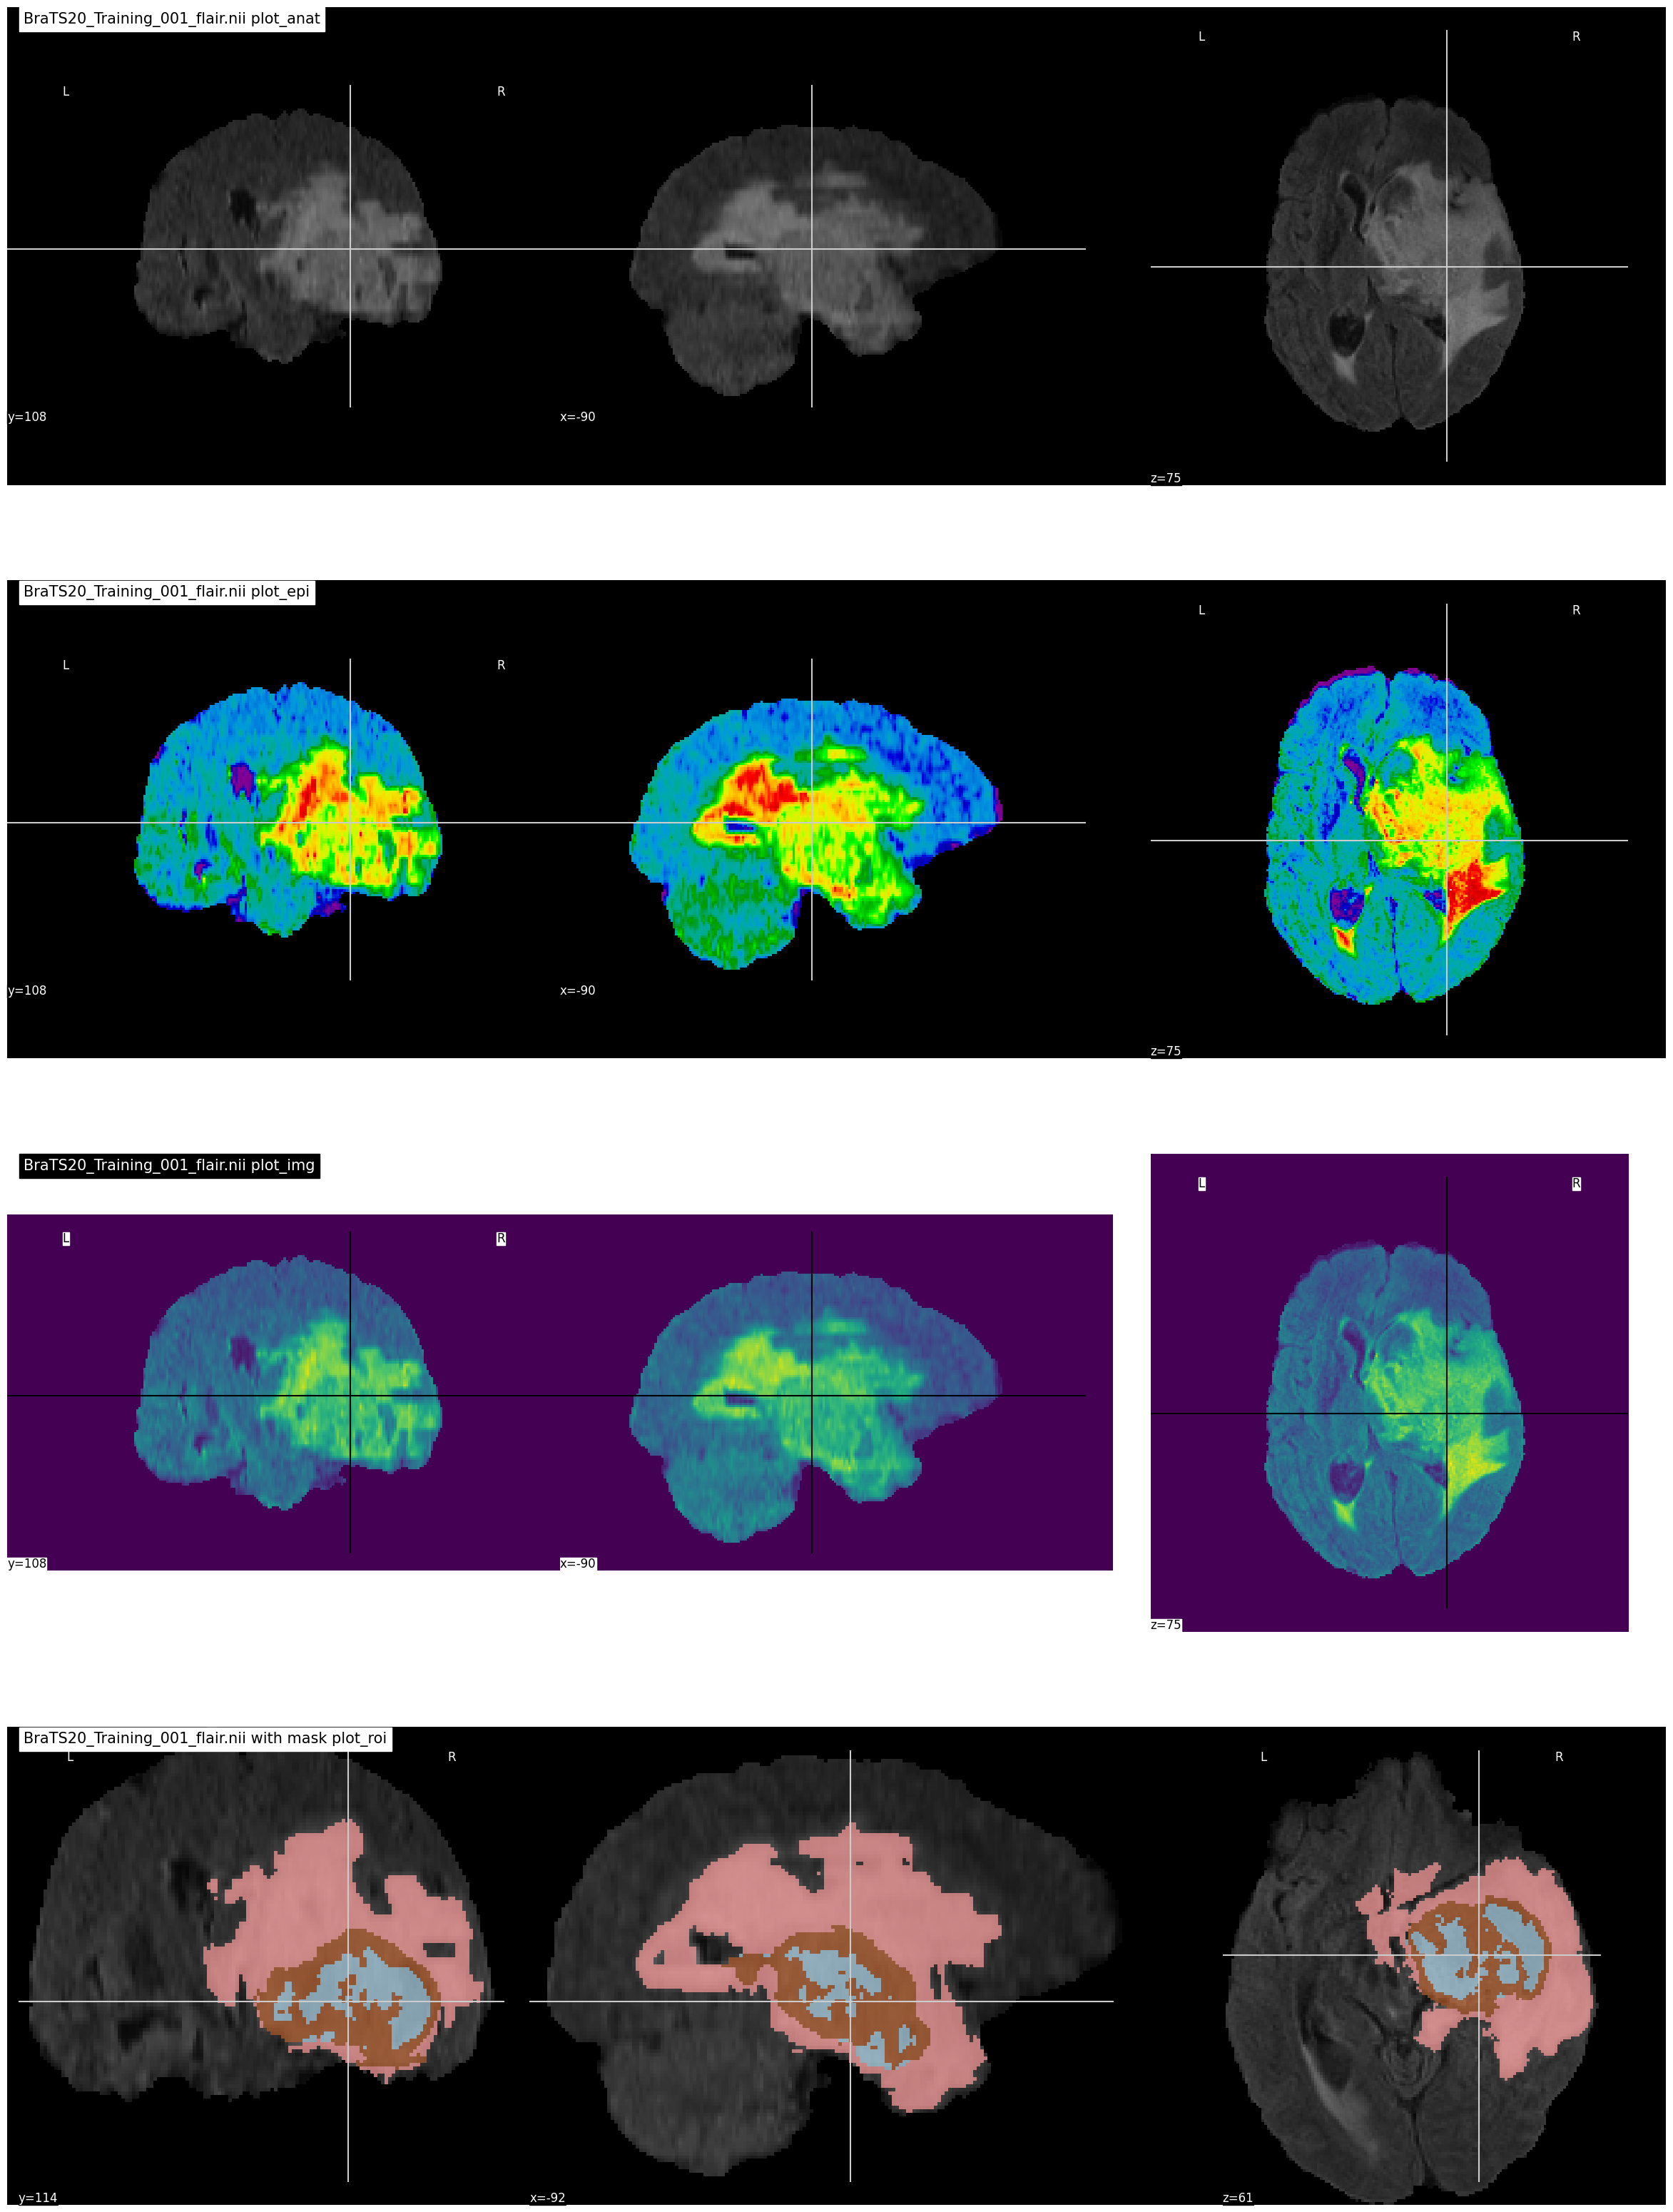

In [12]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    dice_scores = []
    
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:, :, :, i])
        y_pred_f = K.flatten(y_pred[:, :, :, i])
        
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        
        dice_scores.append(dice)
    
    return K.mean(K.stack(dice_scores))


 

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [14]:
IMG_SIZE=128


In [15]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv3D(32, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv3D(32, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv = Conv3D(64, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv3D(64, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv)
    conv2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv5 = Conv3D(512, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv3D(512, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv3D(256, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(drop5))
    merge7 = concatenate([conv3,up7])
    conv7 = Conv3D(256, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv3D(256, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv3D(128, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = Conv3D(128, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv3D(128, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv3D(64, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv8))
    merge9 = concatenate([conv,up9])
    conv9 = Conv3D(64, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv3D(64, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv3D(32, (2,2,2), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling3D(size = (2,2,2))(conv9))
    merge = concatenate([conv1,up])
    conv = Conv3D(32, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv3D(32, (3, 3, 3), activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv3D(4, (1,1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

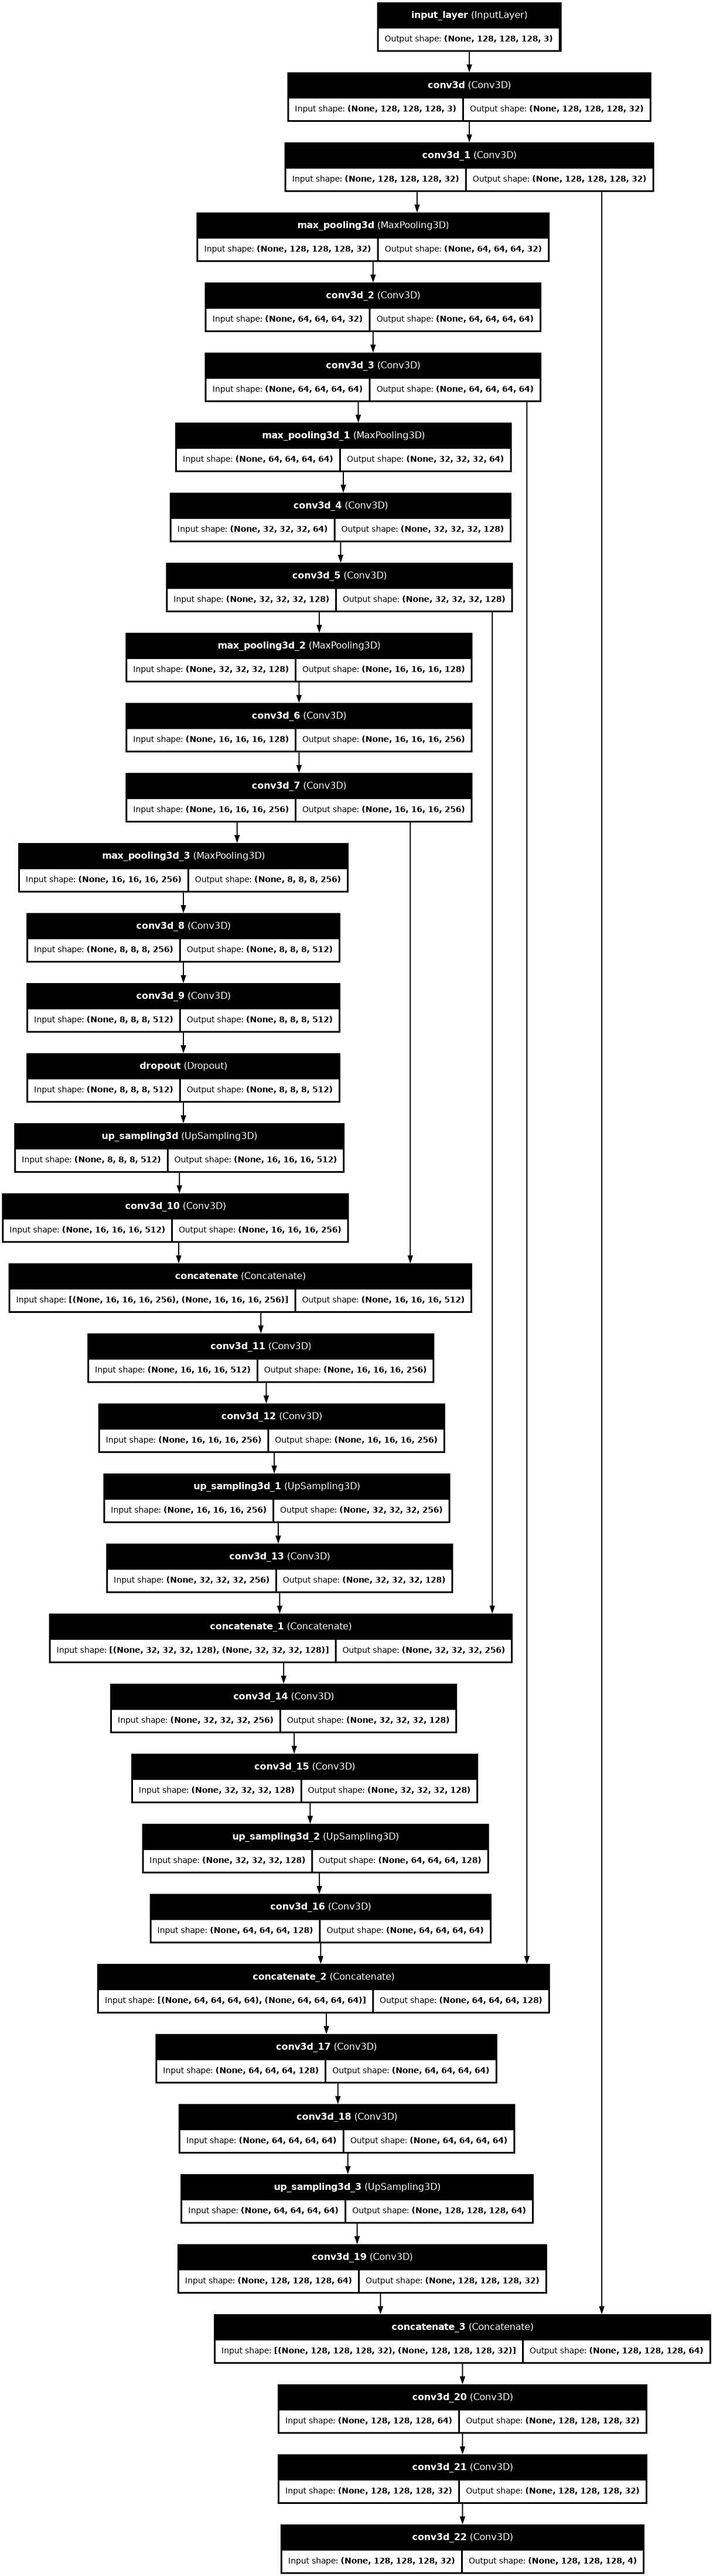

In [16]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [17]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15)

In [18]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

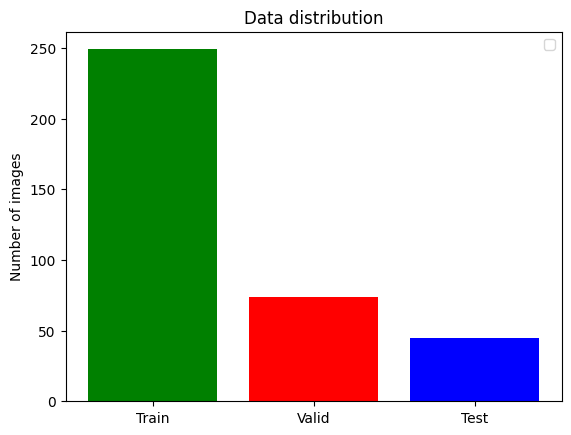

In [19]:

def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [20]:
csv_logger = CSVLogger('training.log', separator=',', append=False)

callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),
        csv_logger
    ]

In [21]:
K.clear_session()


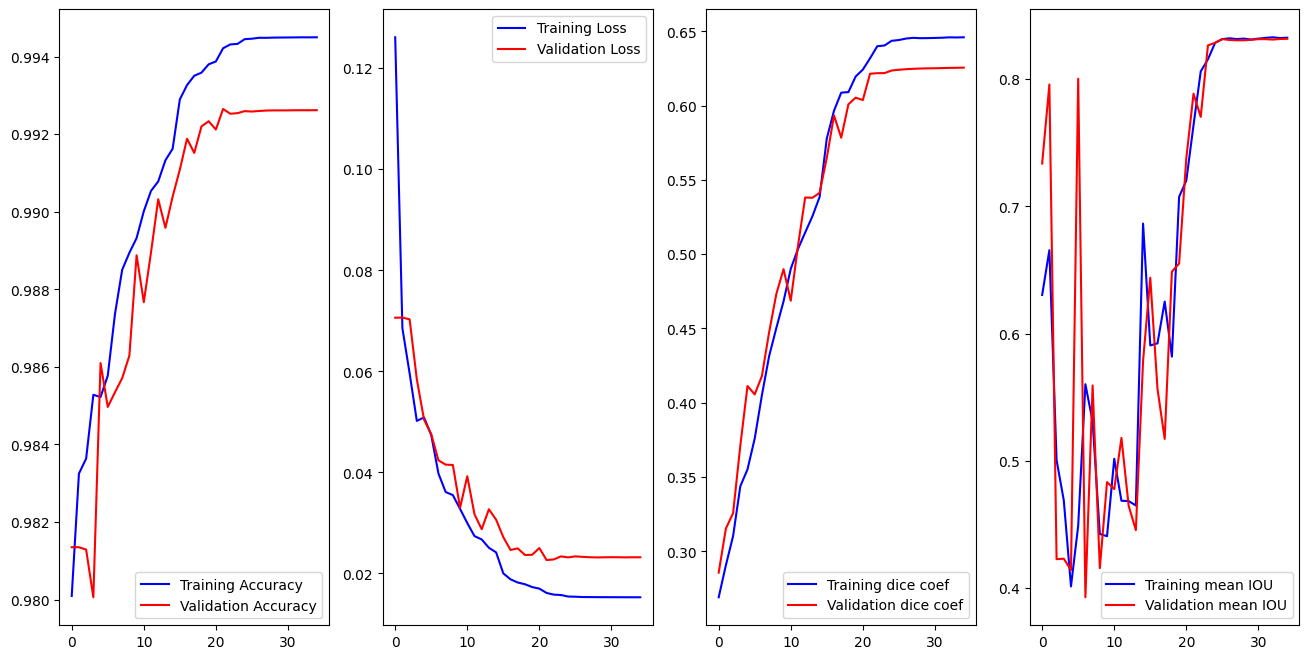

In [22]:
model = keras.models.load_model('/kaggle/input/modelperclasseval/modelperclasseval/model_per_class.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('/kaggle/input/modelperclasseval/modelperclasseval/training_per_class.log', sep=',', engine='python')

hist=history


acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [23]:
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(image[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
    return np.array(image)



def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        


I0000 00:00:1730993973.896514     180 service.cc:145] XLA service 0x7d88c002d380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730993973.896560     180 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/4 ━━━━━━━━━━━━━━━━━━━━ 15s 5s/step

I0000 00:00:1730993978.735580     180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step


<Figure size 1800x5000 with 0 Axes>

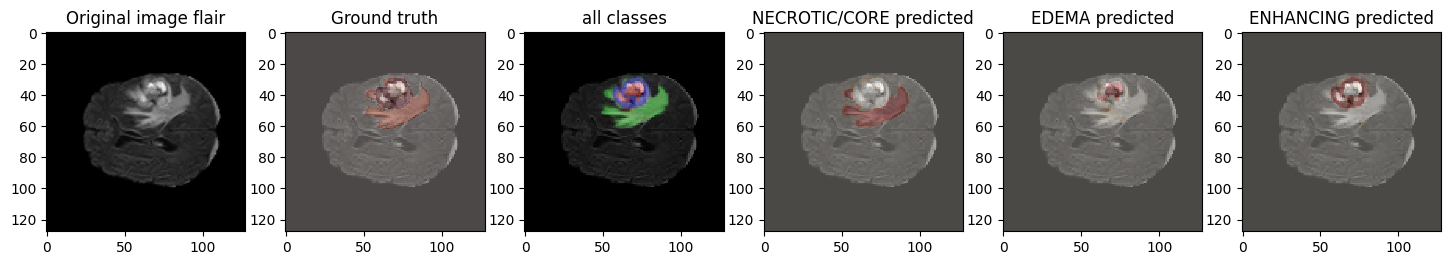

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

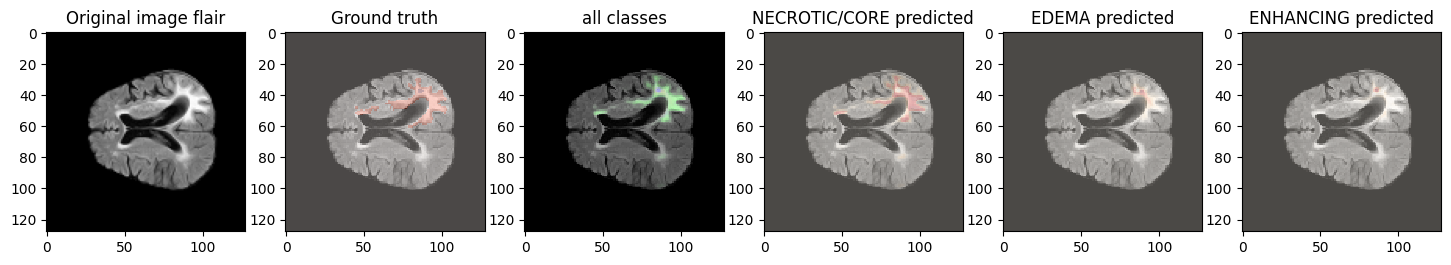

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

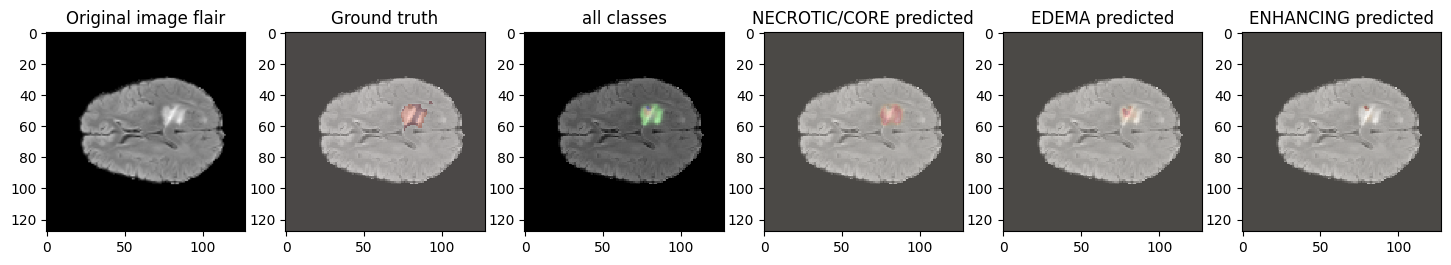

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

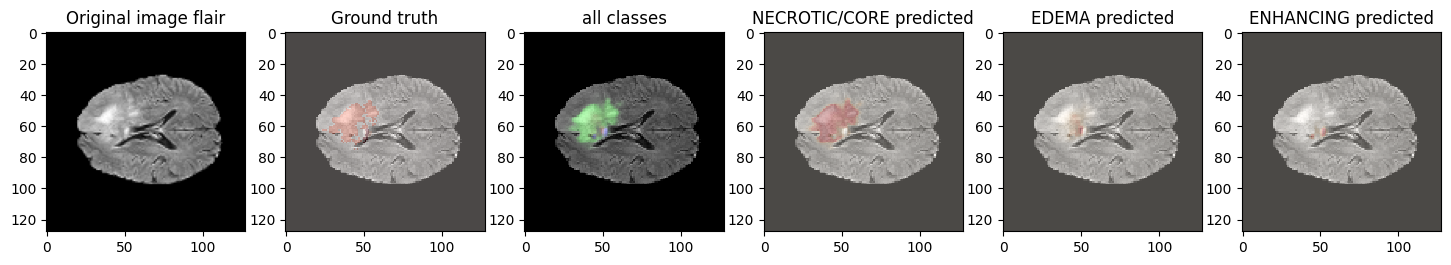

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

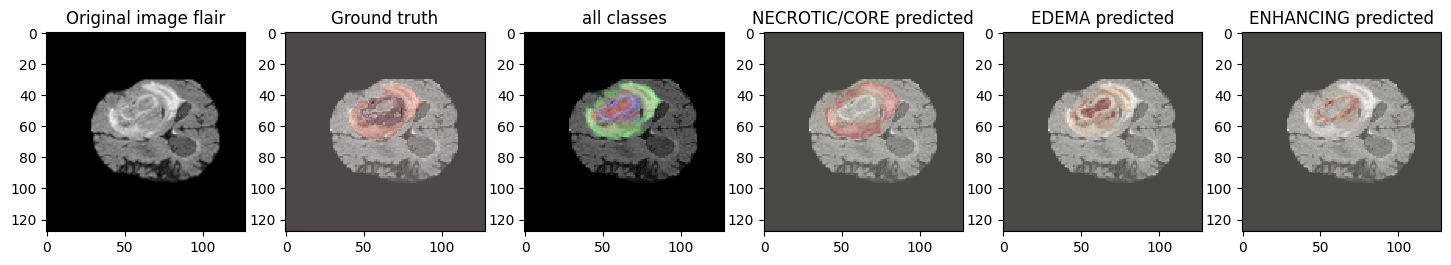

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

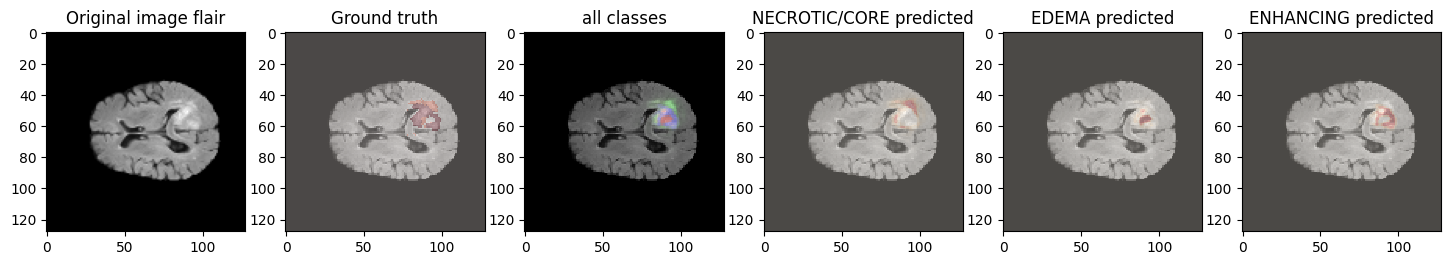

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 1800x5000 with 0 Axes>

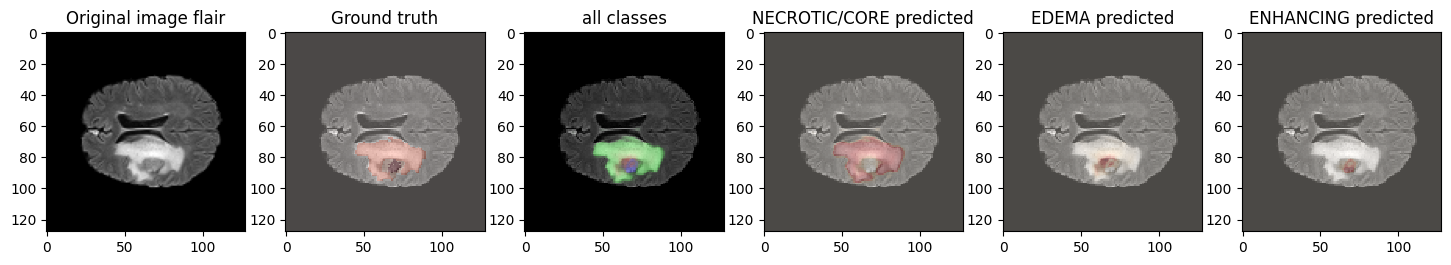

In [24]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
 

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    return model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): 
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
    
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])




4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 640x480 with 0 Axes>

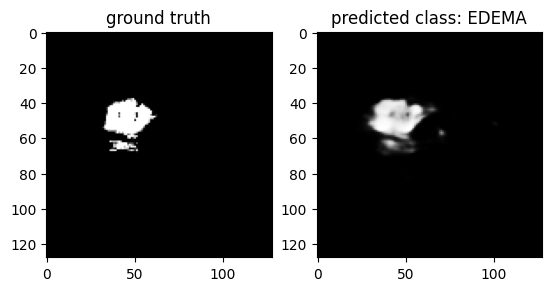

In [25]:
case = case=test_ids[3][-3:]
path = f"../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
p = predictByPath(path,case)


core = p[:,:,:,1]
edema= p[:,:,:,2]
enhancing = p[:,:,:,3]


i=40 
eval_class = 2 



gt[gt != eval_class] = 1  

resized_gt = cv2.resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="gray")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()

In [26]:
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=16, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 53s 939ms/step - accuracy: 0.9935 - dice_coef: 0.6416 - dice_coef_edema: 0.7534 - dice_coef_enhancing: 0.6801 - dice_coef_necrotic: 0.6619 - loss: 0.0188 - mean_io_u_1: 0.6433 - precision: 0.9940 - sensitivity: 0.9919 - specificity: 0.9980
test loss, test acc: [0.01978614740073681, 0.9934282898902893, 0.4999992251396179, 0.6315448880195618, 0.993800938129425, 0.9919359683990479, 0.9979082942008972, 0.5951554775238037, 0.7560681104660034, 0.6887580156326294]


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


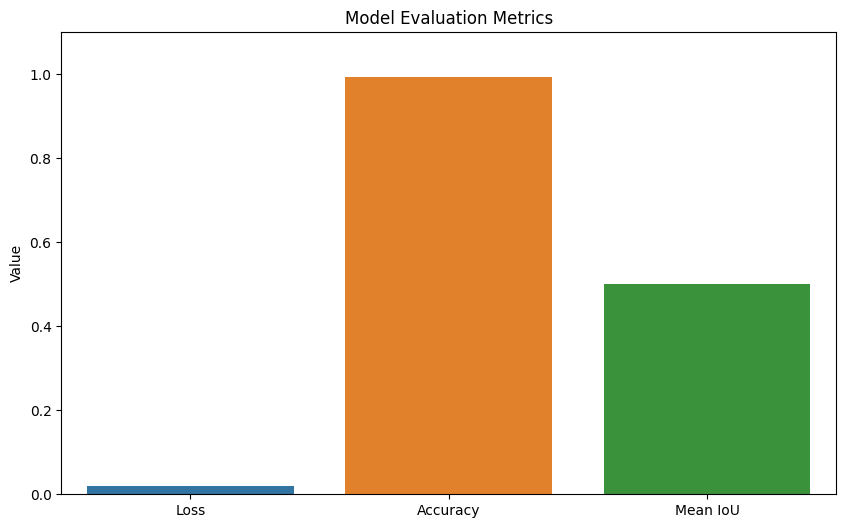

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

test_loss, test_acc, test_mean_iou = results[0], results[1], results[2]

data = [test_loss, test_acc, test_mean_iou]
categories = ["Loss", "Accuracy", "Mean IoU"]

plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=data)

plt.title("Model Evaluation Metrics")
plt.xlabel("")
plt.ylabel("Value")
plt.ylim([0, 1.1])  # Adjust y-axis limits

plt.show()

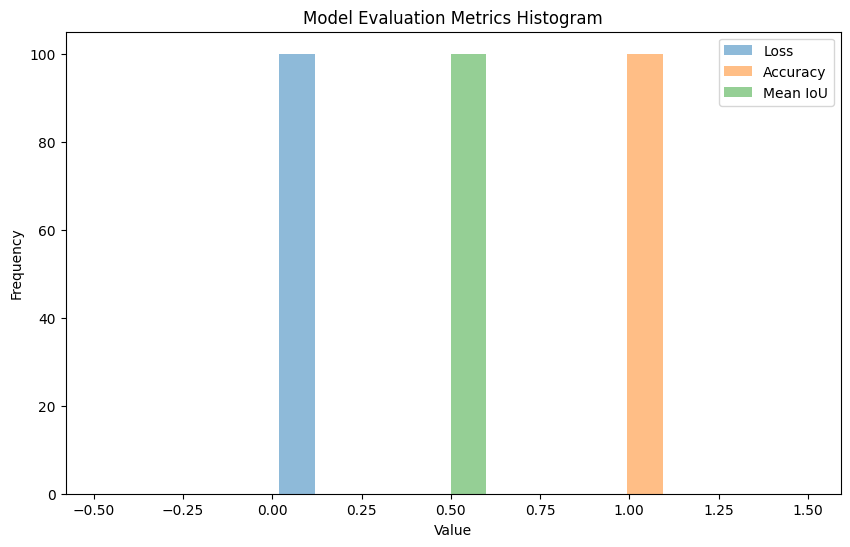

In [28]:
import matplotlib.pyplot as plt
import numpy as np

test_loss, test_acc, test_mean_iou = results[0], results[1], results[2]

data = [test_loss, test_acc, test_mean_iou]
categories = ["Loss", "Accuracy", "Mean IoU"]

plt.figure(figsize=(10, 6))
for i, value in enumerate(data):
    plt.hist([value]*100, alpha=0.5, label=categories[i], bins=10)

plt.title("Model Evaluation Metrics Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()

plt.show()

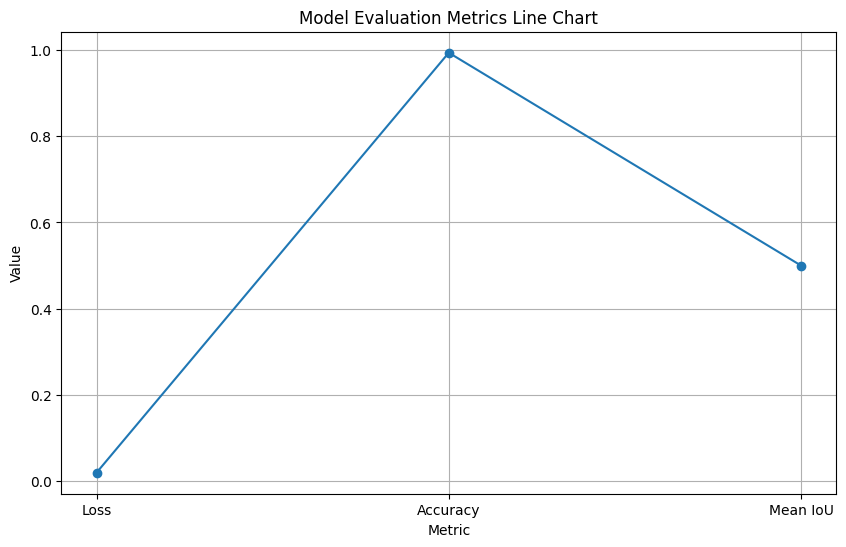

In [29]:
import matplotlib.pyplot as plt
import numpy as np

test_loss, test_acc, test_mean_iou = results[0], results[1], results[2]

data = [test_loss, test_acc, test_mean_iou]
categories = ["Loss", "Accuracy", "Mean IoU"]

plt.figure(figsize=(10, 6))
plt.plot(categories, data, marker='o')

plt.title("Model Evaluation Metrics Line Chart")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.grid(True)

plt.show()

In [35]:
print("Accuracy: ",data[1])
print("Mean IoU: ",data[2])
print("Loss: ",data[0])

Accuracy:  0.9934282898902893
Mean IoU:  0.4999992251396179
Loss:  0.01978614740073681
